In [ ]:
# Importing Important libraries 

# For data cleaning and visualization
import math
import pandas as pd
import numpy as np
from numpy import array
from datetime import date, datetime, timedelta


# For model
from numpy import newaxis
import keras
from keras import optimizers, callbacks
from keras.layers import InputLayer, Input, Masking, Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, callbacks

# For saving the model
import pickle

# For Prediction 
from numpy import newaxis

# For model Evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# For Plotting 
import matplotlib.pyplot as plt
from pylab import rcParams 

In [ ]:
def create_windows(data, data_len, sequence_len=10):
  data_windows = []
  for i in range(data_len - sequence_len):
    data_windows.append(data[i : i+sequence_len])

  # set the type of training data     
  data_windows = np.array(data_windows).astype(float)
  return (data_windows)

In [ ]:
def Normalize_data(data_windows):
  # number of windows formed 
  windows_no = data_windows.shape[0]
  cols_no = data_windows.shape[2]

  # initializing list to store normalized data
  normalized_data = []
  record_min=[]
  record_max=[]

  # normalizing begins
  for win_index in range(windows_no):
    normalized_window = []

    for col_index in range(0,1):
      # temporary column 
      t_col = data_windows[win_index, :, col_index]
      t_min = min(t_col)
      if (col_index == 0):
        record_min.append(t_min)
      t_col = t_col - t_min      
      t_max = max(t_col)
      if (col_index == 0):
        record_max.append(t_max)
      t_col = t_col/t_max
      normalized_window.append(t_col)
    
    for col_index in range(1,  cols_no):
      t_col = data_windows[win_index, :, col_index]
      normalized_window.append(t_col)

    normalized_window = np.array(normalized_window).T
    normalized_data.append(normalized_window)

  normalized_data=np.array(normalized_data)
  return (normalized_data, record_max, record_min)


In [ ]:
def plot_training_loss(model_hist):
  # plotting the lose curve during model training
  plt.plot(model_hist.history['loss'])
  plt.title('Training Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train'],loc='upper left')
  plt.show()


In [ ]:
def Model_Evaluation(actual_prices, predicted_prices):
  # Mean Absolute Error 
  MAE = metrics.mean_absolute_error(actual_prices, predicted_prices)
  # Mean Squared Error
  MSE = metrics.mean_squared_error(actual_prices, predicted_prices)
  # Root Mean Squared Error
  RMSE = np.sqrt(metrics.mean_squared_error(actual_prices, predicted_prices))

  # Mean Absolute Percentage Error in degrees
  errors = abs(actual_prices - predicted_prices)
  MAPE = 100 * (errors /actual_prices)

  # Model Accuracy
  Accuracy = 100 - np.mean(MAPE)
  return (Accuracy, MAE, MSE, RMSE)

In [ ]:
def DP_LSTM(company, df):
  # Adding noise to dataset
  # calculating the variance of the mean_compound column
  news_column  = 'mean_compound'
  mc_var=np.var(df.mean_compound)
  mu=0
  noise=0.1
  sigma_noise = noise*mc_var
  n = df.shape[0]
  # create a dataframe for noise
  df_noise = pd.DataFrame()
  df_noise['mc_noise'] = df[news_column]
  for i in range(0,n):
      df_noise['mc_noise'][i]+=np.random.normal(mu,sigma_noise)  
  noise_name = "mc_noise_"+company+".csv"    
  df_noise.to_csv(noise_name)
  dfn = pd.read_csv(noise_name,index_col=0)
  # creating one dataframe by adding noise in news columns 
  df1 = pd.DataFrame()
  df1['price'] = df['adj_close']
  df1['mc'] = dfn['mc_noise']
  # creating another dataframe by adding normal noise column 
  df2 = pd.DataFrame()
  df2['price'] = df['adj_close']
  df2['mc'] = df['mean_compound']

  # choosing columns for the model
  cols = ['price','mc']
  # deciding the split size
  split = 0.85
  sequence_length=10;
  split_index = int(len(df1) * split)
  data_train1 = df1.get(cols).values[:split_index]
  data_train2 = df2.get(cols).values[:split_index]
  train_len  = len(data_train1)
  train_windows_len = None

  # Normalizing Train data1
  data_windows1 = create_windows(data_train1,train_len,sequence_length)
  normalized_data1,rmax_t1, rmin_t1 = Normalize_data(data_windows1)

  x_train1 = normalized_data1[:, :-1]
  y_train1 = normalized_data1[:, -1,[0]]

  # Normalizing Train data2
  data_windows2 = create_windows(data_train2, train_len,sequence_length)
  normalized_data2,rmax_t2, rmin_t2 = Normalize_data(data_windows2)

  x_train2 = normalized_data2[:, :-1]
  y_train2 = normalized_data2[:, -1,[0]]

  # concatenating the training data
  x_train = np.concatenate((x_train1,x_train2),axis=0)
  y_train = np.concatenate((y_train1,y_train2),axis=0)
  x_train.shape, y_train.shape

  #x_train = x_train1
  #y_train = y_train1

  # Creating the Test Data
  df_test = pd.read_csv(df_name, index_col = 0)
  df_test = df_test.rename(columns = {'adj_close': 'price','mean_compound':'mc'})
  #df_test['date'] = pd.to_datetime(df_test['date'])
  cols = ['price','mc']
  cols2 = ['date']
  test_len = df_test.shape[0]

  data_test  = df_test.get(cols).values[split_index:]
  data_test2  = df_test.get(cols2).values[split_index:]

  data_windows_test = create_windows(data_test, len(data_test), sequence_length)
  # the last price value of each window is the original y_test
  y_test_original = data_windows_test[:, -1, [0]]

  normalized_data_test, record_max_test, record_min_test = Normalize_data(data_windows_test)

  x_test = normalized_data_test[:, :-1]
  y_test = normalized_data_test[:, -1,[0]]

  
  
  # Setting the parameters  
  input_dim=x_train.shape[2] #2
  input_timesteps=x_train.shape[1] #9

  #LSTM Model
  model = Sequential()
  model.add(LSTM(units = 60, activation = 'relu', return_sequences = True,input_shape=(input_timesteps, input_dim)))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 120, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
  hist = model.fit(x_train, y_train, epochs=50, batch_size=32)

  
  plot_training_loss(hist)
  #model_name = company+'_stock_predict_LSTM' 
  #model.save('saved_model/'+model_name)
  # Loading the model
  #model = tf.keras.models.load_model('saved_model/stock_predict_LSTM')

  # Prediction of Test Data using the Training Model
  # Using the trained model for prediction and check the performance metrics
  train_predict = model.predict(x_train)
  test_predict = model.predict(x_test)
  # Multi-sequence Prediction
  # predicting x_test
  prediction_len = 1
  # x_test needs to be predicted 
  data = x_test
  predicted_vals = []
  window_size = sequence_length
  pre_win_no = int(len(data)/prediction_len)
  for i in range(pre_win_no):
    # access x_test window by window
    curr_frame = data[i*prediction_len]
    pred = []
    for j in range(prediction_len):
      # increase the dimension of current frame by one using newaxis, so that it can be fed to model for prediction
      model_predict = model.predict(curr_frame[newaxis,:,:])[0]
      pred.append(model_predict)
      # shift the current frame forward
      curr_frame = curr_frame[1:]
      # insert the currently predicted value in the frame
      # add the new predicted value at the end of window frame 
      curr_frame = np.insert(curr_frame, [window_size-2], pred[-1], axis=0)
    predicted_vals.append(pred)
  print(len(predicted_vals))
  # Denormalizing the Prediction Results to get Predicted Adj Close Price

  pred_prices = []
  len_pre_win = int(len(data)/prediction_len)
  cnt=0
  for i in range(0,len_pre_win):
      for j in range(0,prediction_len):
        pred_prices.append(predicted_vals[i][j][0]*record_max_test[cnt]+record_min_test[cnt])
        cnt = cnt+1


  # Comparing Actual and Predicted Prices
  actual_prices = []
  for i in y_test_original.tolist():
    actual_prices.append(i[0])
  dates = []
  for i in data_test2.tolist():
    dates.append(i[0])
  dates = dates[len(dates)-len(actual_prices):]
  res = { 'date':dates,
        'Actual': actual_prices,
        'Predicted': pred_prices
        }
  df_compare = pd.DataFrame(res,columns = ['date','Actual','Predicted'])
  print(df_compare)

  # Performance Evaluation
  actual_prices = df_compare['Actual']
  predicted_prices = df_compare['Predicted']  

  Accuracy, MAE, MSE, RMSE = Model_Evaluation(actual_prices, predicted_prices)
  print("\n-----Model Evaluation-----------------------------------------------------\n")
  print("LSTM Model Loss = ", model.evaluate(x_test, y_test, verbose = 2))
  print("Model Accuracy = ", Accuracy)
  print("Mean Absolute Error = ", MAE," degrees")
  print("Mean Squared Error = ", MSE)
  print("Root Mean Squared Error = ", RMSE)
  print("\n--------------------------------------------------------------------------\n")
  
  return (hist, model, df_compare, Accuracy, MAE, MSE, RMSE)


In [ ]:
#from google.colab import files
#uploaded = files.upload()

Epoch 1/50
118/118 [==============================] - 15s 85ms/step - loss: 0.2621 - mean_squared_error: 0.2621
Epoch 2/50
118/118 [==============================] - 10s 84ms/step - loss: 0.0963 - mean_squared_error: 0.0963
Epoch 3/50
118/118 [==============================] - 10s 82ms/step - loss: 0.0869 - mean_squared_error: 0.0869
Epoch 4/50
118/118 [==============================] - 10s 83ms/step - loss: 0.0886 - mean_squared_error: 0.0886
Epoch 5/50
118/118 [==============================] - 10s 84ms/step - loss: 0.0855 - mean_squared_error: 0.0855
Epoch 6/50
118/118 [==============================] - 10s 83ms/step - loss: 0.0835 - mean_squared_error: 0.0835
Epoch 7/50
118/118 [==============================] - 10s 84ms/step - loss: 0.0780 - mean_squared_error: 0.0780
Epoch 8/50
118/118 [==============================] - 10s 84ms/step - loss: 0.0782 - mean_squared_error: 0.0782
Epoch 9/50
118/118 [==============================] - 10s 84ms/step - loss: 0.0737 - mean_squared_error:

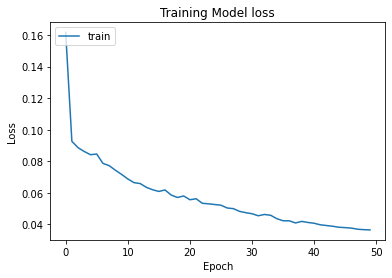

323
           date   Actual    Predicted
0    2018-10-31  2682.63  2688.559054
1    2018-11-01  2711.74  2695.666587
2    2018-11-02  2740.37  2707.110381
3    2018-11-05  2723.06  2718.351686
4    2018-11-06  2738.31  2710.117368
..          ...      ...          ...
318  2020-02-07  3345.78  3342.864157
319  2020-02-10  3327.71  3340.195713
320  2020-02-11  3352.09  3344.349300
321  2020-02-12  3357.75  3351.204419
322  2020-02-13  3379.45  3374.547947

[323 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

11/11 - 1s - loss: 0.0312 - mean_squared_error: 0.0312
LSTM Model Loss =  [0.031235039234161377, 0.031235039234161377]
Model Accuracy =  99.64116030873458
Mean Absolute Error =  10.167809648858414  degrees
Mean Squared Error =  261.28418064497504
Root Mean Squared Error =  16.164287198790273

--------------------------------------------------------------------------



In [ ]:
company="SP500"
df_name = "stock_and_news_SP500.csv"
df = pd.read_csv(df_name, index_col=0)
hist, model, df_compare, Accuracy, MAE, MSE, RMSE = DP_LSTM(company, df)

In [ ]:
results = pd.DataFrame(columns=('company','MAE','MSE','Accuracy','RMSE'))
results = results.append({'company': 'SP500', 'MAE': MAE,'MSE':MSE, 'Accuracy': Accuracy, 'RMSE':RMSE}, ignore_index=True)
results

,company,MAE,MSE,Accuracy,RMSE
0,SP500,10.16781,261.284181,99.64116,16.164287


In [ ]:
now = datetime.now()
current_time = now.strftime("%H%M%S")
name = "P9_LSTM_SP500_dplstm"+current_time+".csv"
results.to_csv(name)